In [313]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import math 
import idx2numpy
import pandas as pd
%matplotlib inline

In [314]:
# load the data 
train_x = idx2numpy.convert_from_file('./data/train-images-idx3-ubyte')
train_y = idx2numpy.convert_from_file('./data/train-labels-idx1-ubyte')
test_x = idx2numpy.convert_from_file('./data/t10k-images-idx3-ubyte')
test_y = idx2numpy.convert_from_file('./data/t10k-labels-idx1-ubyte')

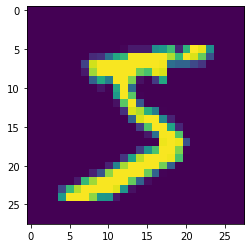

In [315]:
plt.imshow(train_x[0,:])
plt.show()

In [371]:
def createmvn(kernel_matrix): 
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), kernel #tf.linalg.inv(kernel)

In [394]:
# Section 1 Question 2
# Sampling from a centered kernel. 

def create_kernel_matrix(kernelfunc, data):  
    return myarray(data.shape[0], lambda i, j: kernelfunc(data[int(i)] , data[int(j)])) 

def create_normal_distribution(kernel): 
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), kernel
    scale = np.linalg.cholesky(cov)
    return tfp.distributions.MultivariateNormalTriL(loc=mu,scale_tril=scale)

def sampleRKHS(kernelfunc, data, ssize=12, center=True, rkhs_range=(-4,4), func_precision=100, diag_add=1e-6):
    """
    kernelfunc - lambda func that defines the kernel matrix of size dsize x dsize
    dsize - number of elements in the original dataset. 
    ssize - sample size, how many functions from RKHS to sample
    rkhs_range - what range to display the RKHS functions on
    func_precision - how many points to genereate in the rkhs_range (to draw lines) i.e resolution of lines

    returns X, Y -> X: domain values with shape(func_precision, ssize) Y: y values sampled RKHS functions 
    shape(func_precision, ssize) each col represents x and y values of each sampled function. 
    """
    K = create_kernel_matrix(kernelfunc, data) 
    if center:  
        IU = np.identity(data.shape[0]) - np.full((data.shape[0], data.shape[0]), 1 / data.shape[0])
        K = np.matmul(IU, np.matmul(K, IU))
    K += np.identity(data.shape[0]) * diag_add


    mvn = create_normal_distribution(K) 
    xi = np.linspace(rkhs_range[0], rkhs_range[1], func_precision) # this will be the domain we will be looking at of the RKHS space. 

    # create a matrix that will store the domains of the sampled value (linespace).
    # each column will be the same since we are analyzing them in the same domain.  
    y = np.reshape(xi.T, (xi.shape[0], 1)) # create a transpose of x (since each col will represent the points we are eval at)
    X_f = y
    X_k = y
    for i in range (0, ssize - 1): # range == # of datums in original dataset. 
        X_f = np.concatenate((X_f, y), axis=1)
    
    for i in range(0, data.shape[0] - 1): 
        X_k = np.concatenate((X_k, y), axis=1)

    
    # create functions evaluated at the 10 different basis functions 
    # each basis function is a kernel evaluated at each point holding second variable constant. 
    # in this case we are evaluating the second variable at (almost) all possible points (large number of rows representing domain)
    Kx = np.zeros((X_k.shape[0], data.shape[0]))


    for i in range(Kx.shape[0]): 
        for j in range(Kx.shape[1]):
            Kx[i, j] = kernelfunc(data[j], X_k[i, j])
    
    
    # now create the weighted functions now representing the actual functions in RKHS. 
    alphas = mvn.sample([ssize]).numpy() # sample the alpha weights by which each kernel function will be weighed. 
    # each fx will need its own alpha. Amount sampled is the amount of sample functions we want to generate. 
    Fx = np.matmul(Kx, alphas.T)
    return X_f, Fx, alphas

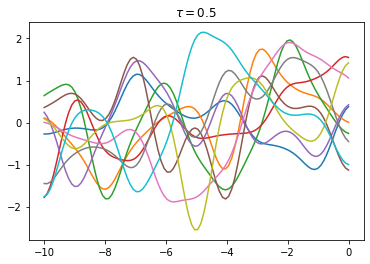

In [395]:
t=0.5
gk = lambda i, j: np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )
data = np.array([i for i in range(-10, 1)])
x,y,a = sampleRKHS(gk, data, diag_add=1e-6, rkhs_range=(-10,0))
plt.title(r'$\tau = 0.5$')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])
#plt.savefig("./latex/figures/t05.pdf")